<a href="https://colab.research.google.com/github/IMGW-univie/thunder-seis/blob/main/ThunderSeis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required dependencies

In [ ]:
!pip install geopandas -q
!pip install contextily -q
!pip install adjustText -q
!pip install obspy -q

#There is a bug in Obspy when working in Colab, 
#so we need to restart the enviroment, 
#IGNORE the errors popping
#and simply run next cells

import os
os.kill(os.getpid(), 9)

In [1]:
#@title Import required libraries and define functions (double-click to see the code)

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from scipy import stats

from obspy import UTCDateTime
from obspy.clients.fdsn import RoutingClient
import obspy
from obspy.signal.trigger import z_detect, trigger_onset, plot_trigger, recursive_sta_lta, classic_sta_lta

from obspy.signal.freqattributes import central_frequency_unwindowed, peak_ground_motion
from obspy.signal.polarization import polarization_analysis

from astropy.stats import circmean
from astropy import units as u

from IPython.display import clear_output

import geopandas
from osgeo import gdal
import contextily as ctx
from adjustText import adjust_text

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from matplotlib import cm

from shapely.geometry import box
from rasterio.mask import mask
import rasterio
import fiona
from shapely.geometry import mapping

import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def filter_record(record, freqs):
    #Filter waveform
    record_filtered = record.copy()
    record_filtered.taper(max_percentage=0.1, max_length=5)
    record_filtered.filter('bandpass', freqmin=freqs[0], freqmax=freqs[1], zerophase=True)
    record_filtered.taper(max_percentage=0.1, max_length=5)
    record_filtered.detrend('demean')
    record_filtered.detrend('linear')
    return record_filtered

def find_event(record, row, starttime):
    if len(record) > 0:
        #Select Z channel and run STA/LTA
        trace = record.select(channel='*Z')[0]
        sr = trace.stats.sampling_rate
        cft = recursive_sta_lta(trace.data, int(1 * sr), int(30 * sr))
        
#         plt.plot(cft)
        
        thres_1 = row['thres_on']
        thres_2 = row['thres_off']
        
#         print(thres_1, thres_2)
        
        trig_onset = trigger_onset(cft, thres_1, thres_2)
        #Find out interval
        for trig in trig_onset:
            arrival = (pd.Timestamp(row.arrival_time).timestamp()-starttime.timestamp) * sr
            origin = (pd.Timestamp(row['timestamp']).timestamp()-starttime.timestamp) * sr

            if (arrival >= trig[0]-row['bound']*sr) & (arrival <= trig[1]+row['bound']*sr) & (trig[0] > origin):

                row['trig_on'] = trig[0]
                row['trig_off'] = trig[1]

                starttime_lightning = UTCDateTime(starttime.timestamp+trig[0]/sr)
                endtime_lightning   = UTCDateTime(starttime.timestamp+trig[1]/sr)
                return starttime_lightning, endtime_lightning, trig[0], trig[1]
                break
            
    else: print('Empty trace')

def pol2cart(distance, azimuth, incidence):
    '''
    𝑥=ρsinφcosθ 
    𝑦=ρsinφsinθ 
    𝑧=ρcosφ

    distance - 0, +inf
    azimuth - 0, 2pi
    incidence - 0, pi
    '''
    azimuth = np.deg2rad(azimuth)
    incidence = np.deg2rad(incidence)
    
    x = distance * np.sin(incidence) * np.cos(azimuth)
    y = distance * np.sin(incidence) * np.sin(azimuth)
    z = distance * np.cos(incidence)
    return x, y, z


def compute_params(db, iloc, freqs, lightning_disp=False):
    row  = db.iloc[iloc] #Select record from database
    starttime = UTCDateTime(pd.Timestamp(row.timestamp)) - 30 #Set starttime
    endtime = UTCDateTime(pd.Timestamp(row.arrival_time)) + 60 #Set endtime

    lightning_bound = 0.25

    record = obspy.read('/content/SEISMIC_DATA/%s_%s.MSEED' % (db.iloc[iloc].station, db.iloc[iloc].timestamp), format='mseed')

    fs = record[0].stats.sampling_rate 
    
    record_filtered = filter_record(record, freqs)

    if lightning_disp==False:
        starttime_lightning, endtime_lightning, trig_0, trig_1 = find_event(record_filtered, row, starttime)

        row['trig_on'], row['trig_off'] = trig_0, trig_1
            
        record_unfiltered_selected = record.copy().trim(starttime=starttime_lightning, endtime=endtime_lightning)
        record_filtered_selected = record_filtered.copy().trim(starttime=starttime_lightning, endtime=endtime_lightning)

        row['signal_width'] = (row['trig_off'] - row['trig_on'])/fs
        
        #Polarization analysis
        if len(record) > 1:
            pol = polarization_analysis(record_filtered, win_len=1, win_frac=0.1, 
                                        frqlow=freqs[0], frqhigh=freqs[1],
                                        stime=record_filtered[0].stats.starttime+1, 
                                        etime=record_filtered[0].stats.endtime-1, 
                                        method='flinn')
            rel_timestamp = pol['timestamp']- starttime.timestamp
            
            weights = (np.abs(record_filtered[0].data)[::int(0.1*fs)][:len(pol['timestamp'])] +\
                    np.abs(record_filtered[1].data)[::int(0.1*fs)][:len(pol['timestamp'])] +\
                    np.abs(record_filtered[2].data)[::int(0.1*fs)][:len(pol['timestamp'])])
            
            weights_full = weights[(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)]
            weights_1s = weights[(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)][:10]
            
            selected_azimuth = pol['azimuth'][(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)]
            selected_incidence = pol['incidence'][(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)]
            time = rel_timestamp[(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)]
            
            distance = ((time-30) * 345)
            
            elevation = row['Elevation [km]']*1000
            
            row['azimuth_full_width'] = circmean(selected_azimuth*u.deg, weights=weights_full)
            row['azimuth_first_1s'] = circmean(selected_azimuth[:10]*u.deg, weights=weights_1s)

            row['incidence_full_width'] = np.mean(selected_incidence)
            row['incidence_first_1s'] = np.mean(selected_incidence[:10])

            row['planarity_full_width'] = np.mean(pol['planarity'][(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)])
            row['planarity_first_1s'] = np.mean(pol['planarity'][(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)][:10])

            row['rectilinearity_full_width'] = np.mean(pol['rectilinearity'][(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)])
            row['rectilinearity_first_1s'] = np.mean(pol['rectilinearity'][(rel_timestamp > row['trig_on']/fs) & (rel_timestamp < row['trig_off']/fs)][:10])
            
            x,y,z = pol2cart(distance, selected_azimuth, selected_incidence)
            z = z+elevation

            row['altitude_min'] = z.min()
            row['altitude_mean'] = z.mean()
            row['altitude_max'] = z.max()
            
        for channel, indx in zip(['Z'], range(1)):
            row['baseline_Z'] = np.abs(np.median(record_filtered_selected[0].data))

            record_lightning = record_filtered.copy().trim(starttime=UTCDateTime(pd.Timestamp(row.timestamp))-lightning_bound, 
                                                        endtime=UTCDateTime(pd.Timestamp(row.timestamp))+lightning_bound)
                                                
            row['max_disp_at_lightning_Z'] = np.abs(record_lightning.select(channel=('*'+channel))[0].data).max()
            
            row['lightning_power_Z'] = np.sum(np.abs(record_lightning.select(channel=('*'+channel))[0].data))/(lightning_bound*2)
            
            row['disp_random_Z'] = np.abs(record_filtered.select(channel=('*'+channel))[0].data[np.random.randint(0,len(record_filtered.select(channel=('*'+channel))[0].data))])
            rand_start = np.random.randint(0,len(record_filtered.select(channel=('*'+channel))[0].data)-(lightning_bound*2)*fs)
            rand_end = int(rand_start + (lightning_bound*2)*fs)
            row['random_power_Z'] = np.sum(np.abs(record_filtered.select(channel=('*'+channel))[0].data[rand_start:rand_end]))/(rand_end-rand_start)
            
            row['Max_disp_full_no_filters_Z'] = np.abs(record_unfiltered_selected.select(channel=('*'+channel))[0].data).max()
            row['CF_full_no_filters_Z'] = central_frequency_unwindowed(data=record_unfiltered_selected.select(channel=('*'+channel))[0].data, fs=fs)
            
            row['Max_disp_%i_%i_Z' % (freqs[0], freqs[1])] = np.abs(record_filtered_selected.select(channel=('*'+channel))[0].data).max()
            row['CF_%i_%i_Z' % (freqs[0], freqs[1])] = central_frequency_unwindowed(data=record_filtered_selected.select(channel=('*'+channel))[0].data, fs=fs)
            
            
            row['Max_time_%i_%i_Z' % (freqs[0], freqs[1])] = record_filtered_selected.select(channel=('*'+channel))[0].times('timestamp')[np.argmax(np.abs(record_filtered_selected.select(channel=('*'+channel))[0].data))]
            
            row['disp_per_time_%i_%i_Z' % (freqs[0], freqs[1])] = np.sum(record_filtered_selected.select(channel=('*'+channel))[0].data**2)/(row['signal_width']*fs)
            
            if len(record) <= 1:
                break

        for freq_band in zip([1,10,20,30,40,1], [10,20,30,40,49,49]):
            record_freq = filter_record(record, freq_band)
            
            record_freq_selected = record_freq.copy().trim(starttime=starttime_lightning, endtime=endtime_lightning)
            
            for channel, indx in zip(['Z'], range(1)):
                row['Max_disp_%i_%i_%s' % (freq_band[0], freq_band[1], channel)] = np.abs(record_freq_selected.select(channel=('*'+channel))[0].data).max()
                row['CF_%i_%i_%s' % (freq_band[0], freq_band[1], channel)] = central_frequency_unwindowed(data=record_freq_selected.select(channel=('*'+channel))[0].data, fs=fs)
                if len(record) <= 1:
                    break
            
            row['arrival_time'] = row.arrival_time
            row['timestamp'] = row.timestamp
            
            row['offset'] = row['trig_on']/fs - (pd.Timestamp(row.arrival_time).timestamp()-starttime.timestamp)
            min_time = row.Max_time_10_49_Z
            row['offset_max'] = (min_time-starttime.timestamp) - (pd.Timestamp(row.arrival_time).timestamp()-starttime.timestamp)

        return record, record_filtered, pol, row.to_frame().T
    else:
        return record, record_filtered

def annotate(data, **kws):
    r, p = stats.pearsonr(data['abs_ampl'], data['log_MD'])
    ax = plt.gca()
    ax.text(.05, .8, 'R={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

def crop_dem(minx, miny, maxx, maxy, in_tif, nodata=2147483647):
    bbox = box(minx, miny, maxx, maxy)
    
    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    with fiona.open('bbox.shp', 'w', 'ESRI Shapefile', schema, crs='EPSG:4326') as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(bbox),
            'properties': {'id': 123},
        })

    with fiona.open("bbox.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(in_tif) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, )
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "nodata": np.nan})
    out_image = out_image.astype('float32')
    out_image[out_image == nodata] = np.nan
    return out_image[0]


# Data Loading

## Get selected stations

In [ ]:
# !rm -rf thunder-seis/
# !rm -rf SEISMIC_DATA/

In [2]:
%cd /content/
!git clone https://github.com/IMGW-univie/thunder-seis.git

/content
fatal: destination path 'thunder-seis' already exists and is not an empty directory.


For the sake of demonstartion (and due to restrictions imposed by ALDIS) we provide sample of 20 datapoints selected (5 in each category) from our database. If you want to have more data please reach out to `artemii.novoselov@univie.ac.at` and the data would be made available to you.

In [3]:
db_selected = pd.read_csv('/content/thunder-seis/SELECTED_DATA.csv')
db_selected.head(3)

,Unnamed: 0,Station name,Elevation [km],num,date,nano,st_x,st_y,amplitude,nbloc,numloc,icloud,flash,maxis,axisratio,inclin,rise,width,numgsp,nbgsp,nblocgsp,ngc,nbcg,timestamp,distance,station,station_y,station_x,back_azimuth,beg_time,end_time,N_arrivals,id,thres_on,thres_off,bound,trig_on,trig_off,signal_width,azimuth_full_width,...,CF_vel_20_30_Z,Max_disp_20_30_R,CF_20_30_R,CF_vel_20_30_R,Max_disp_20_30_T,CF_20_30_T,CF_vel_20_30_T,Max_disp_30_40_Z,CF_30_40_Z,CF_vel_30_40_Z,Max_disp_30_40_R,CF_30_40_R,CF_vel_30_40_R,Max_disp_30_40_T,CF_30_40_T,CF_vel_30_40_T,Max_disp_40_49_Z,CF_40_49_Z,CF_vel_40_49_Z,Max_disp_40_49_R,CF_40_49_R,CF_vel_40_49_R,Max_disp_40_49_T,CF_40_49_T,CF_vel_40_49_T,Max_disp_1_49_Z,CF_1_49_Z,CF_vel_1_49_Z,Max_disp_1_49_R,CF_1_49_R,CF_vel_1_49_R,Max_disp_1_49_T,CF_1_49_T,CF_vel_1_49_T,lightning,polarity,polarity_code,arrival_time,actual_velocity,actual_velocity_max
0,0,A003A,0.116,20639376,2020-08-10 18:12:19+00:00,87167744,17.012300,47.711498,-10.54,1,1,False,True,0.096000,1.31507,106.199997,2.5,19.0,1.0,1.0,1.0,1.0,1.0,2020-08-10 18:12:19.087167+00:00,9066.110352,A003A,47.758926,17.053045,210.034241,2020-08-10 18:11:49.087167+00:00,2020-08-10 18:13:45.365746+00:00,2,2440206,4.5,0.5,10,4402,5835,14.33,49.805191,...,24.742401,1.923241e-09,24.228065,24.732223,1.252009e-09,25.363234,25.832195,1.480445e-09,36.458959,36.737105,1.574504e-09,34.563590,35.108996,2.291870e-09,35.452952,35.684115,6.896568e-09,45.937752,45.758782,2.872664e-09,46.866024,46.415139,3.234683e-09,45.971607,45.814094,3.803358e-08,5.278792,42.230230,6.731196e-08,1.868587,26.210485,3.599568e-08,4.361030,38.352699,NaN,Negative,0,2020-08-10 18:12:45.365746+00:00,646.655517,494.798495
1,1,A004A,0.200,3099115,2017-06-25 02:47:48+00:00,967595776,16.432699,47.995701,-8.51,1,1,False,True,0.313000,2.07285,73.000000,6.3,3.8,1.0,1.0,1.0,1.0,1.0,2017-06-25 02:47:48.967595+00:00,6765.421875,A004A,47.962883,16.396784,36.210812,2017-06-25 02:47:18.967595+00:00,2017-06-25 02:49:08.577513+00:00,1,3539237,2.5,1.0,5,4911,6074,11.63,101.837341,...,25.027584,2.627740e-10,22.377125,22.809323,1.931075e-10,23.010155,23.619770,2.883608e-10,33.958551,34.433159,1.965919e-10,34.271921,34.667511,1.181904e-10,33.878941,34.258970,2.840704e-10,47.049654,47.178397,1.452994e-10,48.408694,48.360029,1.628112e-10,48.260373,48.209165,3.965202e-08,1.424743,8.501821,3.363609e-08,1.510568,8.531280,3.955480e-08,1.689427,5.788832,NaN,Negative,0,2017-06-25 02:48:08.577513+00:00,354.025216,338.653689
2,2,A006A,0.230,15669408,2016-06-02 15:56:31+00:00,695077888,15.955100,48.649799,-6.71,1,1,True,True,0.065493,1.55686,82.300003,4.5,3.5,NaN,NaN,NaN,NaN,1.0,2016-06-02 15:56:31.695077+00:00,16912.634766,A006A,48.740379,16.020298,205.436905,2016-06-02 15:56:01.695077+00:00,2016-06-02 15:58:20.717206+00:00,1,2611436,4.0,0.1,15,5363,9976,46.13,102.912598,...,23.005044,4.647177e-09,23.025446,23.411482,2.859861e-09,23.463375,23.886052,1.522038e-09,34.729658,35.296101,1.653275e-09,35.813646,36.254871,1.870896e-09,34.383173,34.706567,5.177509e-09,46.898980,46.763409,7.952072e-09,46.705882,46.592834,5.404934e-09,47.035661,46.984564,9.418093e-08,7.142050,20.835338,6.852566e-08,7.289517,31.545603,6.642919e-08,8.262568,19.786442,NaN,Negative,0,2016-06-02 15:57:20.717206+00:00,715.727244,378.147878


We can see that attributes already computed, but let's compute them again so the whole computation pipleline is transparent

## Download seismic data

In [4]:
#@title Since there are some incompatibilities between Google Colab and Obspy run this cell only if working locally (double-click to see the code)
# def download_waveform(network='Z3', 
#                       station='A001A', 
#                       starttime='2016-01-01 00:00:00.00T',
#                       endtime='2016-01-01 00:01:00.00T'):
    
#     st = client.get_waveforms(
#             network = network,
#             station=station,
#             channel="*",
#             starttime=starttime,
#             endtime=endtime
#         )

#     inv = client.get_stations(network=network,
#                             station=station,
#                             channel="*", 
#                             level='response')  
#     return st, inv

# client = RoutingClient("eida-routing")
# network = 'Z3'
# station = db_selected.iloc[0].station
# starttime = UTCDateTime(pd.Timestamp(db_selected.iloc[0].timestamp)) - 30
# endtime = UTCDateTime(pd.Timestamp(db_selected.iloc[0].arrival_time)) + 60

# st, inv = download_waveform(network=network, 
#                             station=station, 
#                             starttime=starttime,
#                             endtime=endtime)

As an alternative lets read saved data from the disk

In [5]:
!unzip /content/thunder-seis/SEISMIC_DATA.zip
clear_output()

Now we can finally compute our attributes

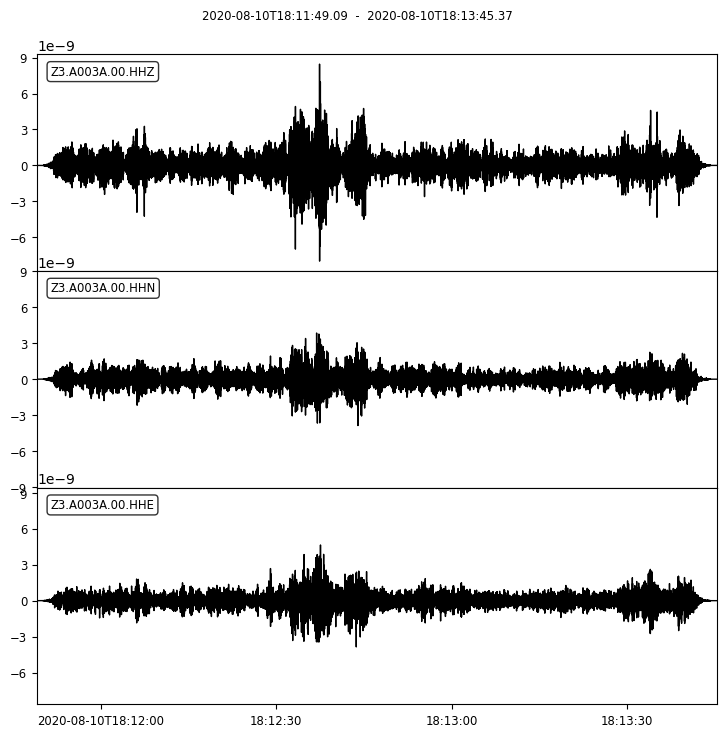

In [6]:
iloc = 0
freqs = [10., 49.0] #Select frequency range
record, record_filtered, pol, attributes = compute_params(db_selected, iloc, freqs)
record_filtered.plot();

Lets verify that we indeed computed the same thing as in the paper

In [7]:
np.isclose(db_selected['max_disp_at_lightning_Z'].iloc[iloc], attributes['max_disp_at_lightning_Z'].values[0], atol=1e-10)

True

# Results

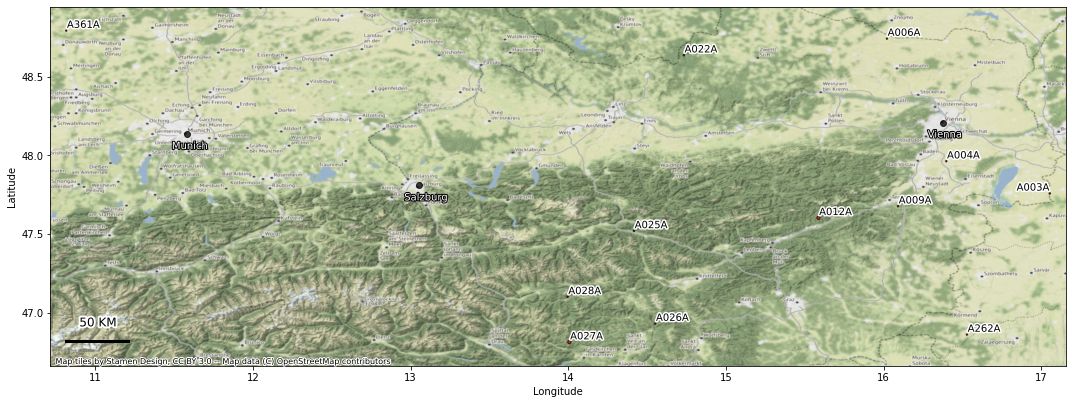

In [8]:
#@title Produce figure 2 (double-click to see the code)

#Convert station data to Geopandas
gdf_stations = geopandas.GeoDataFrame(
    db_selected, geometry=geopandas.points_from_xy(db_selected.station_x, db_selected.station_y))
gdf_stations = gdf_stations.set_crs(epsg=4326)
# gdf_stations = gdf_stations.to_crs(epsg=3857)

gdf_stations = pd.merge(
                gdf_stations.drop_duplicates(subset='station'),
                gdf_stations.groupby('station')['num'].count(),
                how="left",
                on='station',
)

#Create entries for major cities
cities = pd.DataFrame({'city' : ['Vienna', 'Salzburg', 'Munich'], 
                                 'lat'  : [48.2082, 47.8095, 48.1351],
                                 'lon'  : [16.3738, 13.0550, 11.5820]})

gdf_cities = geopandas.GeoDataFrame(
    cities, geometry=geopandas.points_from_xy(cities.lon, cities.lat))
gdf_cities = gdf_cities.set_crs(epsg=4326)

#Plot the map
fig, ax = plt.subplots(nrows=1, figsize=(15,15))

ax_1 = gdf_stations.plot(ax = ax, figsize=(10, 10), alpha=0.75, markersize=gdf_stations['num_y']*2, color='red', edgecolor='black')
ax_2 = gdf_cities.plot(ax = ax, figsize=(10, 10), alpha=0.75, color='black')

minx, miny, maxx, maxy = gdf_stations.geometry.total_bounds

extent = 0.1
ax_1.set_xlim(minx - extent, maxx + extent) # added/substracted value is to give some margin around total bounds
ax_1.set_ylim(miny - extent*1.5, maxy + extent*1.5)

#Label each station
text = [ax.text(gdf_stations.geometry.x[i], gdf_stations.geometry.y[i], gdf_stations.station[i]) for i in range(len(gdf_stations))]
for txt in text:
    txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
adjust_text(text)

#Label cities
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities.city):
    text = ax.annotate(label, xy=(x, y), xytext=(-15, -15), textcoords="offset points", color='white')
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
ctx.add_basemap(ax_1, source=ctx.providers.Stamen.Terrain, crs=gdf_stations.crs.to_string())

#Add scale bar
x, y, scale_len = minx, miny, 0.008*50
scale_rect = Rectangle((x,y), scale_len, 0.01, linewidth=2, edgecolor='k', facecolor='k')
ax.add_patch(scale_rect)
text = plt.text(x+scale_len/2, y+0.1, s='50 KM', fontsize=12, horizontalalignment='center')
text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
                       path_effects.Normal()])

divider = make_axes_locatable(ax)

ax.set_ylabel('Latitude');
ax.set_xlabel('Longitude');

plt.tight_layout()
# fig.savefig('AlpArray.pdf', dpi=720)

**Figure 2**. a) AlpArray seismic stations used in this study.  The size of symbols shows thenumber of thunder events registered by the stations

Note that this version of the figure plots only selected 20 events

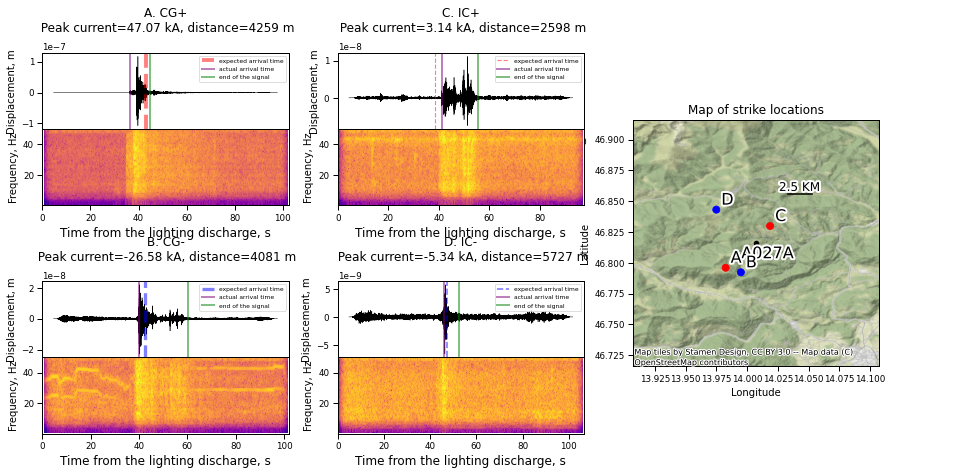

In [9]:
#@title Produce figure 3 (double-click to see the code)

#Add category column for simplicity
db_selected['category'] = ''
db_selected['category'][(db_selected['polarity'] == 'Positive') & (db_selected['icloud'] == False)] = 'CG+'
db_selected['category'][(db_selected['polarity'] == 'Negative') & (db_selected['icloud'] == False)] = 'CG-'
db_selected['category'][(db_selected['polarity'] == 'Positive') & (db_selected['icloud'] == True)] = 'IC+'
db_selected['category'][(db_selected['polarity'] == 'Negative') & (db_selected['icloud'] == True)] = 'IC-'

#Select examples
db_selection = db_selected[
    (db_selected['icloud'] == False) &
    (db_selected['amplitude'] > 0) &
    (db_selected['nbloc'] == 1) &
    (db_selected['N_arrivals'] == 1) &
    (db_selected.station == 'A027A')
].sort_values('distance')

gc_plus = db_selection.iloc[0].to_frame().T

db_selection = db_selected[
    (db_selected['icloud'] == False) &
    (db_selected['amplitude'] < 0) &
    (db_selected['nbloc'] == 1) &
    (db_selected['N_arrivals'] == 1) &
    (db_selected.station == 'A027A')
].sort_values('distance')

gc_minus = db_selection.iloc[0].to_frame().T

db_selection = db_selected[
    (db_selected['icloud'] == True) &
    (db_selected['amplitude'] > 0) &
    (db_selected['nbloc'] == 1) &
    (db_selected['N_arrivals'] == 1) &
    (db_selected.station == 'A027A')
].sort_values('distance')

ic_plus = db_selection.iloc[0].to_frame().T

db_selection = db_selected[
    (db_selected['icloud'] == True) &
    (db_selected['amplitude'] < 0) &
    (db_selected['nbloc'] == 1) &
    (db_selected['N_arrivals'] == 1) &
    (db_selected.station == 'A027A')
].sort_values('distance')

ic_minus = db_selection.iloc[0].to_frame().T

db_selection_long = pd.concat([gc_plus, gc_minus, ic_plus, ic_minus])

#Plot figure
sns.set_context('paper')

fig = plt.figure(figsize=(15,7))
gs = fig.add_gridspec(nrows=5, ncols=3, hspace=0.0)

ax_trace_0 = fig.add_subplot(gs[0, 0])
ax_spectrum_0 = fig.add_subplot(gs[1, 0])

ax_trace_1 = fig.add_subplot(gs[3, 0])
ax_spectrum_1 = fig.add_subplot(gs[4, 0])

ax_trace_2 = fig.add_subplot(gs[0, 1])
ax_spectrum_2 = fig.add_subplot(gs[1, 1])

ax_trace_3 = fig.add_subplot(gs[3, 1])
ax_spectrum_3 = fig.add_subplot(gs[4, 1])

for iloc, ax_trace, ax_spectrum, letter in zip(range(4), 
                                       [ax_trace_0, ax_trace_1, ax_trace_2, ax_trace_3], 
                                       [ax_spectrum_0, ax_spectrum_1, ax_spectrum_2, ax_spectrum_3],
                                       ['A','B','C','D']):
    row  = db_selection_long.iloc[iloc] #Select record from database
    starttime = UTCDateTime(pd.Timestamp(row.timestamp)) - 0 #Set starttime
    endtime = starttime + 40 #Set endtime

    freqs = [10., 49.0] #Select frequency range
    record, record_filtered, pol, attributes = compute_params(db_selection_long, iloc, freqs)

    fs = record[0].stats.sampling_rate 

    Z_filtered = record_filtered.select(channel='*Z')[0]
    ax_trace.plot(Z_filtered.times(), Z_filtered.data, color='black', lw=0.5)
    Z_filtered.spectrogram(axes=ax_spectrum, dbscale=True, cmap='plasma')

    ax_trace.axvline(pd.Timestamp(row['arrival_time']).timestamp()-starttime.timestamp + 30, 
                      color=['blue' if row['amplitude'] < 0 else 'red'][0], 
                      linewidth = np.abs(np.log(np.abs(row['amplitude']))),
                      linestyle='dashed', alpha=0.5, label='expected arrival time')
    
    ax_trace.axvline(pd.Timestamp(row.timestamp).timestamp()-starttime.timestamp + row.trig_on/100, 
                      color='purple', 
                      linewidth = 2,
                      linestyle='solid', alpha=0.5, label='actual arrival time')
    
    ax_trace.axvline(pd.Timestamp(row.timestamp).timestamp()-starttime.timestamp + row.trig_off/100, 
                      color='green', 
                      linewidth = 2,
                      linestyle='solid', alpha=0.5, label='end of the signal')
    
    ax_trace.legend(ncol=1, loc='upper right', fontsize=6)
    ax_trace.set_title('%s. %s\n Peak current=%.2f kA, distance=%.0f m\n' % (letter,
                                                                             row['category'], 
                                                                             row['amplitude'], 
                                                                             row['distance']), fontsize=12);
    ax_trace.set_ylabel('Displacement, m', fontsize=10)
    ax_spectrum.set_ylabel('Frequency, Hz', fontsize=10)
    ax_spectrum.set_xlabel('Time from the lighting discharge, s', fontsize=12)

ax_map = fig.add_subplot(gs[:, 2:])

gdf_lightnings = geopandas.GeoDataFrame(
    db_selection_long, geometry=geopandas.points_from_xy(db_selection_long.st_x, db_selection_long.st_y))
gdf_lightnings = gdf_lightnings.set_crs(epsg=4326)

gdf_stations = geopandas.GeoDataFrame(
    db_selection_long, geometry=geopandas.points_from_xy(db_selection_long.station_x, db_selection_long.station_y))
gdf_stations = gdf_stations.set_crs(epsg=4326)

gdf_lightnings['color'] = ''
gdf_lightnings['color'][gdf_lightnings['category'].isin(['CG+', 'IC+'])] = 'red'
gdf_lightnings['color'][gdf_lightnings['category'].isin(['CG-', 'IC-'])] = 'blue'

ax_lightning = gdf_lightnings.plot(ax = ax_map, figsize=(10, 10), 
                                                c=gdf_lightnings['color'], 
                                                markersize=50)

ax_station = gdf_stations.iloc[[0]].plot(ax = ax_map, figsize=(10, 10), color='black')

minx, miny, maxx, maxy = gdf_stations.iloc[[iloc]].geometry.total_bounds

#Adjust those accordingly if working with your own data
ax_station.set_xlim(minx - 0.1, maxx + 0.1) # added/substracted value is to give some margin around total bounds
ax_station.set_ylim(miny - 0.1, maxy + 0.1)

for x, y, label in zip(gdf_stations.iloc[[iloc]].geometry.x, gdf_stations.iloc[[iloc]].geometry.y, gdf_stations.iloc[[iloc]].station):
    text = ax_map.annotate(label, xy=(x, y), xytext=(-15, -15), textcoords="offset points", fontsize=16)
    text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
                       path_effects.Normal()])
    
for x, y, label in zip(gdf_lightnings.geometry.x, gdf_lightnings.geometry.y, ['A','B','C','D']):
    text = ax_map.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", color='black', fontsize=16)
    text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
                       path_effects.Normal()])
    
ctx.add_basemap(ax_station, source=ctx.providers.Stamen.Terrain, crs=gdf_stations.crs.to_string())
ax_station.set_title('Map of strike locations', fontsize=12)
ax_station.set_ylabel('Latitude', fontsize=10)
ax_station.set_xlabel('Longitude', fontsize=10)

# #Add scale-bar
x, y, scale_len = minx+0.025, miny+0.04, 0.008*2.5
scale_rect = Rectangle((x,y), scale_len, 0.001, linewidth=0.5, edgecolor='k', facecolor='k')
ax_station.add_patch(scale_rect)
text = plt.text(x+scale_len/2, y+0.0025, s='2.5 KM', fontsize=12, horizontalalignment='center')
text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
                       path_effects.Normal()])

# fig.savefig('Lightning_examples.pdf')
# # fig.suptitle('Seismic record of lightning strikes')

**Figure 3**. Examples of thunder signals from a) positive Cloud-to-Ground lightning, b) negative Cloud-to-Ground lightning, c) positive Intra-Cloud lightning, and d) negative Intra-Cloud lightning recorded at the seismic station A027A. Dashed lines show the expected time of acoustic arrival (assuming the speed of sound $c=345$ m/s), purple solid lines show the actual beginning of the thunder signal, green solid lines show the end of the thunder signal as defined by STA/LTA.

## Statistical distributions

We are not at liberty to redistribute ALDIS data, but we can use our derivative as long as it doesn't contain the location and time as we please. Therefore let's load those

In [10]:
db_selected_without_times = pd.read_csv('/content/thunder-seis/DATA_without_times.csv')
db_selected_without_times.head(3)

,arrival_time,amplitude,icloud,distance,station,station_y,station_x,Max_disp_10_49_Z,CF_1_49_Z,CF_vel_1_49_Z,polarity,trig_on,trig_off,offset_max,actual_velocity,actual_velocity_max
0,2017-07-30 17:38:50.690686+00:00,-12.69,False,472.016,A263A,46.6408,17.3149,8.323114e-08,14.419818,32.945585,Negative,3117,3582,-0.200686,403.432393,404.304660
1,2016-07-26 15:16:20.601430+00:00,-5.12,False,624.704,A022A,48.6348,14.7326,3.219371e-08,33.676052,37.067442,Negative,3172,3764,0.498570,363.199846,270.515883
2,2016-04-08 09:27:27.403730+00:00,42.53,False,974.500,A003A,47.7589,17.0530,2.011715e-07,8.101129,43.210733,Positive,3828,5279,5.586270,117.693259,115.861468


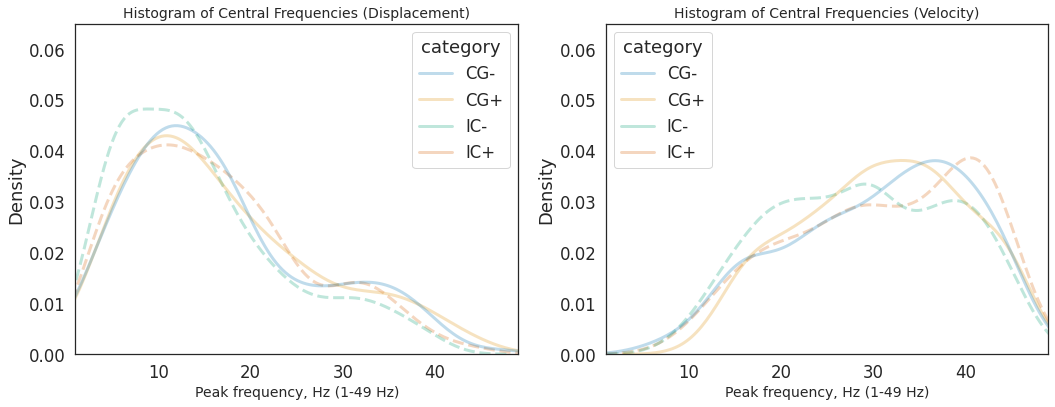

In [12]:
#@title Produce Figure 5 (double-click to see the code)
sns.reset_orig()
sns.set_context('paper')
sns.set(font_scale=1.5, style='white', palette=sns.color_palette("colorblind", 4))

#Add category column for simplicity
db_selected_without_times['category'] = ''
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Positive') & (db_selected_without_times['icloud'] == False)] = 'CG+'
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Negative') & (db_selected_without_times['icloud'] == False)] = 'CG-'
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Positive') & (db_selected_without_times['icloud'] == True)] = 'IC+'
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Negative') & (db_selected_without_times['icloud'] == True)] = 'IC-'

fig, ax = plt.subplots(ncols=2, figsize=(15,6))

sns.kdeplot(x="CF_1_49_Z", hue="category", data=db_selected_without_times,
                    alpha=0.25,
#                  col='polarity',
#                  palette="seismic", 
#                  palette = {'Positive' : '#c1121f', 'Negative' : '#003049'},
#                  stat='density', 
                 common_norm=False, 
#              kde=True,
#                  line_kws={'linewidth':3},
             linewidth=3,
#                  log_scale=True,
                 ax=ax[0]
                );
ax[0].lines[0].set_linestyle('--')
ax[0].lines[1].set_linestyle('--')

ampl = sns.kdeplot(x="CF_vel_1_49_Z", hue="category", data=db_selected_without_times,
                    alpha=0.25,
#                  col='polarity',
#                  palette="seismic", 
#                  palette = {'Positive' : '#c1121f', 'Negative' : '#003049'},
#                  stat='density', 
                 common_norm=False, 
#                     kde=True,
                    linewidth=3,
#                      line_kws={'linewidth':3},
#                  log_scale=True,
                 ax=ax[1]
                );
ax[1].lines[0].set_linestyle('--')
ax[1].lines[1].set_linestyle('--')

for a in ax:
    a.set_xlabel('Peak frequency, Hz (1-49 Hz)', fontsize=14)
    a.set_xlim(1,49)
    a.set_ylim(0,0.065)
ax[0].set_title('Histogram of Central Frequencies (Displacement)', fontsize=14)
ax[1].set_title('Histogram of Central Frequencies (Velocity)', fontsize=14)

# ax[1].set_xlabel('Peak frequency, Hz (1-49 Hz)')
# ax[1].set_xlabel('')
plt.tight_layout()
# fig.savefig('Peak_frequencies.pdf')
# ax.set(xlim=(0,60))

**Figure 5.** Left panel: The histogram of peak frequencies of thunder displacements. 
Right panel: Distribution (kde plot) of peak frequencies of thunder velocities (histogram areas are 1). Dashed lines - Intracloud lightnings (- and +), solid lines - Cloud-to-Ground lightnings (- and +).

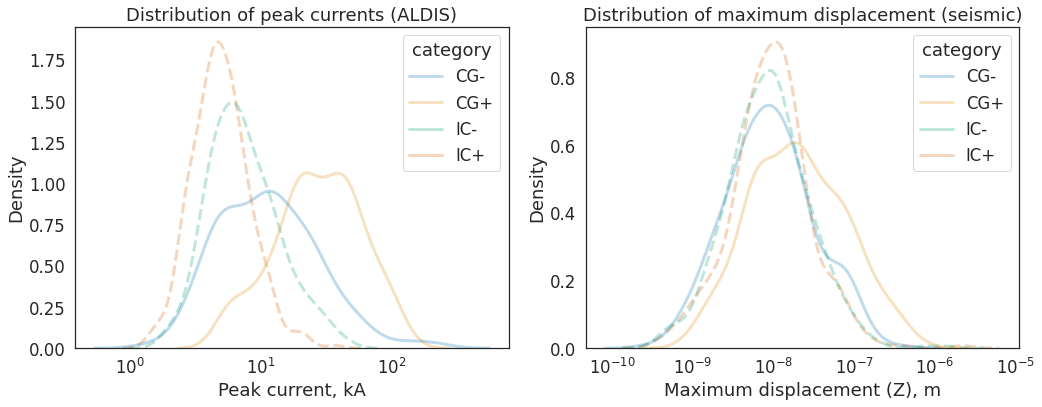

In [13]:
#@title Produce figure 6 (double-click to see the code)
#Create absolute amplitude column
db_selected_without_times['abs_ampl'] = db_selected_without_times['amplitude'].abs()

#Add category column for simplicity
db_selected_without_times['category'] = ''
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Positive') & (db_selected_without_times['icloud'] == False)] = 'CG+'
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Negative') & (db_selected_without_times['icloud'] == False)] = 'CG-'
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Positive') & (db_selected_without_times['icloud'] == True)] = 'IC+'
db_selected_without_times['category'][(db_selected_without_times['polarity'] == 'Negative') & (db_selected_without_times['icloud'] == True)] = 'IC-'

#Plot the figure
sns.reset_orig()
sns.set_context('paper')
sns.set(font_scale=1.5, style='white', palette=sns.color_palette("colorblind", 4))

fig, ax = plt.subplots(ncols=2, figsize=(15,6))

#Peak currents from ALDIS
sns.kdeplot(x="abs_ampl", hue="category", data=db_selected_without_times,
                    alpha=0.25,
                    common_norm=False, 
                    linewidth=3,
                    log_scale=True,
                    ax=ax[0]
                    );
ax[0].lines[0].set_linestyle('--')
ax[0].lines[1].set_linestyle('--')

#Peak displacements from AlpArray
ampl = sns.kdeplot(x="Max_disp_10_49_Z", hue="category", data=db_selected_without_times,
                    alpha=0.25,
                    common_norm=False, 
                    linewidth=3,
                    log_scale=True,
                    ax=ax[1]
                    );
ax[1].lines[0].set_linestyle('--')
ax[1].lines[1].set_linestyle('--')

ax[0].set_xlabel('Peak current, kA')
ax[1].set_xlabel('Maximum displacement (Z), m')

ax[0].set_title('Distribution of peak currents (ALDIS)')
ax[1].set_title('Distribution of maximum displacement (seismic)')

plt.tight_layout()
# fig.savefig('Amplitudes.pdf')
# ax.set(xlim=(0,60))

**Figure 6**. Left panel shows the distribution of absolute peak currents measured by ALDIS, and the right panel the maximum displacements on Z channel, recorded by AlpArray seismic stations (histogram areas are 1). The data distributions for CG+ are shifted towards higher values.

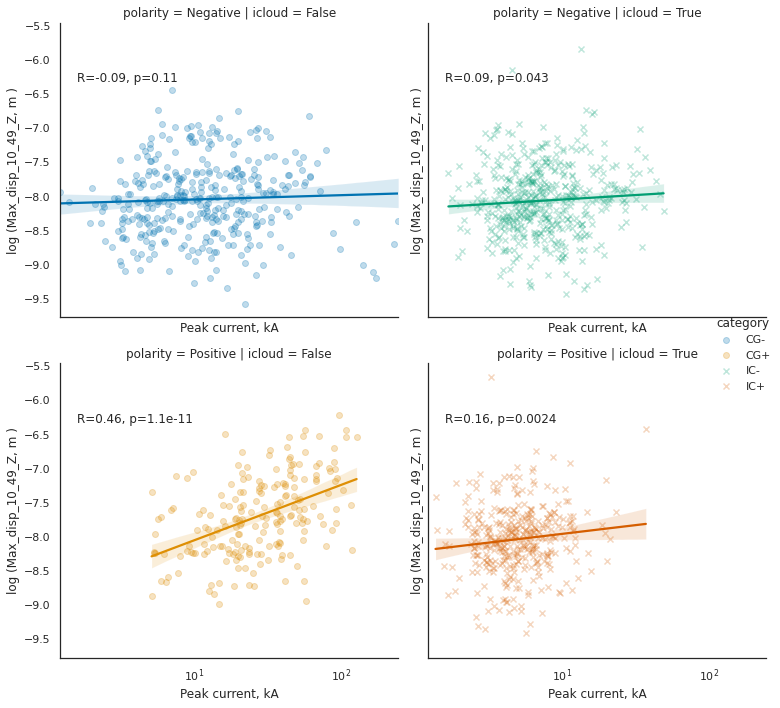

In [ ]:
#@title Produce figure 7 (double-click to see the code)
sns.reset_orig()
sns.set_context('paper')
sns.set(font_scale=1, style='white', palette=sns.color_palette("colorblind", 4))

y_name = 'Max_disp_10_49_Z'
x_name = 'abs_ampl'

db_selected_without_times['log_amplitude'] = np.log10(db_selected_without_times['amplitude'].abs())

db_selected_without_times['MD'] = db_selected_without_times[y_name]

db_selected_without_times['log_MD'] = np.log10(db_selected_without_times['MD'])
db_selected_without_times['abs_ampl'] = db_selected_without_times['amplitude'].abs()
db_selected_without_times = db_selected_without_times.dropna(subset=[y_name])

ax = sns.lmplot(x=x_name, y="log_MD", hue="category",
                col='icloud',
                row='polarity', 
                data=db_selected_without_times,
                scatter_kws={'alpha':0.25}, 
                markers=['o','o','x','x'],
                logx=True);


ax.set(xscale='log')

g = ax.map_dataframe(annotate)
ax.set(xlabel='Peak current, kA', ylabel='log (%s, m )' % y_name)
plt.tight_layout()

# plt.savefig('Regression.pdf')

**Figure 7**. Correlation between recorded energy, distance between estimated lightning location and peak current, kA. Blue symbols illustrate Cloud-to-Ground lightning discharges, orange crosses correspond to Intra-Cloud lightning discharges. Rows show absolute values of positive and negative currents. Note that both axes are plotted in logarithmic scale.

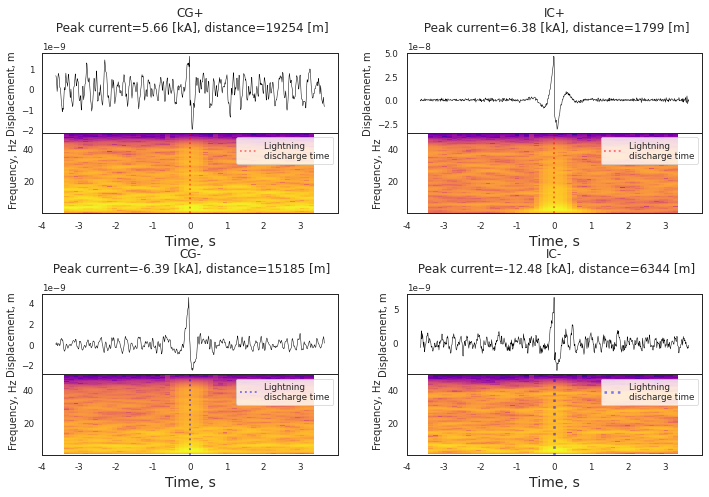

In [ ]:
#@title Produce Figure 8 (double-click to see the code)
db_lightning = db_selected[db_selected.lightning == True]

import seaborn as sns
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_context('paper')

fig = plt.figure(figsize=(15,7))
gs = fig.add_gridspec(nrows=5, ncols=3, hspace=0.0)

ax_trace_0 = fig.add_subplot(gs[0, 0])
ax_spectrum_0 = fig.add_subplot(gs[1, 0])

ax_trace_1 = fig.add_subplot(gs[3, 0])
ax_spectrum_1 = fig.add_subplot(gs[4, 0])

ax_trace_2 = fig.add_subplot(gs[0, 1])
ax_spectrum_2 = fig.add_subplot(gs[1, 1])

ax_trace_3 = fig.add_subplot(gs[3, 1])
ax_spectrum_3 = fig.add_subplot(gs[4, 1])

for iloc, ax_trace, ax_spectrum, letter in zip(range(4), 
                                       [ax_trace_0, ax_trace_1, ax_trace_2, ax_trace_3], 
                                       [ax_spectrum_0, ax_spectrum_1, ax_spectrum_2, ax_spectrum_3],
                                       ['A','B','C','D']):
    freqs = [1.5, 40.0] #Select frequency range

    row  = db_lightning.iloc[iloc] #Select record from database
    starttime = UTCDateTime(pd.Timestamp(row.timestamp)) - 4 #Set starttime
    endtime = UTCDateTime(pd.Timestamp(row.timestamp)) + 4 #Set endtime

    record, record_filtered = compute_params(db_lightning, iloc, freqs, lightning_disp=True)
    
    record_filtered.trim(starttime=starttime, endtime=endtime)


    Z_filtered = record_filtered.select(channel='*Z')[0]
    ax_trace.plot(Z_filtered.times(), Z_filtered.data, color='black', lw=0.5)
    Z_filtered.spectrogram(axes=ax_spectrum, dbscale=True, cmap='plasma')
    
    ax_spectrum.axvline(pd.Timestamp(row['timestamp']).timestamp()-starttime.timestamp, 
                      color=['blue' if row['amplitude'] < 0 else 'red'][0], 
                      linewidth = np.abs(np.log(np.abs(row['amplitude']))),
                      linestyle='dotted', alpha=0.5, label='Lightning \ndischarge time')
    ax_spectrum.legend()
    ax_spectrum.set_xticklabels(np.arange(-4,4,1))
    ax_trace.set_title('%s\n Peak current=%.2f [kA], distance=%.0f [m]\n' % (
                                                                             row['category'], 
                                                                             row['amplitude'], 
                                                                             row['distance']), fontsize=12);
    ax_trace.set_ylabel('Displacement, m', fontsize=10)
    ax_spectrum.set_ylabel('Frequency, Hz', fontsize=10)
    ax_spectrum.set_xlabel('Time, s', fontsize=14)

plt.tight_layout()
# fig.savefig('Lightning_electrical_examples.pdf')
# # fig.suptitle('Seismic record of lightning strikes')

**Figure 8.** Examples of seismometer signals at the time of lightning, from a) positive Cloud-to-Ground lightning, b) negative Cloud-to-Ground lightning, c) positive Intra-Cloud lightning, d) negative Cloud-to-Ground lightning recorded at various stations. The size of symbols on the map shows the percentage of lightning events out of total detections per given station. Those pulses were not observed on any of the remaining stations. Data is filtered with a zero-phase bandpass filter from 1.5 to 40 Hz.

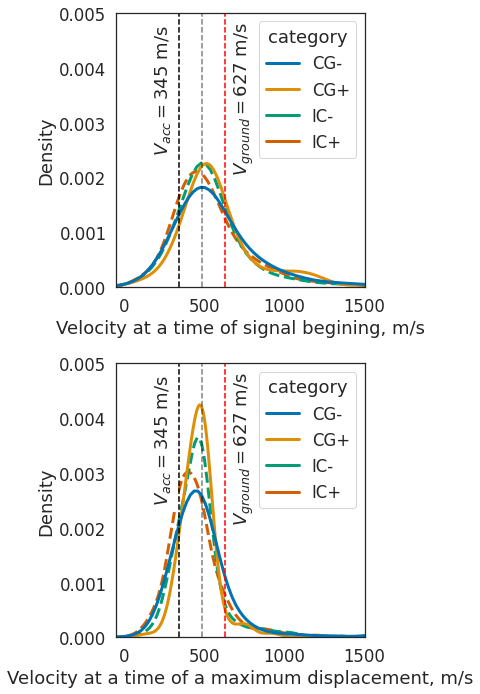

In [ ]:
#@title Produce Figure 9 (double-click to see the code)
sns.reset_orig()
sns.set_context('paper')
sns.set(font_scale=1.5, style='white', palette=sns.color_palette("colorblind", 4))

fig, ax = plt.subplots(nrows=2, figsize=(6,10))
b = sns.kdeplot(x="actual_velocity", hue='category',
                 data=db_selected_without_times,
                 common_norm=False, 
                 alpha=0.15,
                 linewidth=3,
                  ax=ax[0]
                );
ax[0].lines[0].set_linestyle('--')
ax[0].lines[1].set_linestyle('--')

k = sns.kdeplot(x="actual_velocity_max", hue='category',
                 data=db_selected_without_times,
                 common_norm=False, 
                 alpha=0.15,
                linewidth=3,
                  ax=ax[1]
                );
ax[1].lines[0].set_linestyle('--')
ax[1].lines[1].set_linestyle('--')

b.set_xlabel('Velocity at a time of signal begining, m/s')
k.set_xlabel('Velocity at a time of a maximum displacement, m/s')
for a in ax:
    a.set_xlim(-50,1500)
    a.axvline(345, linestyle='--', color='black')
    a.text(s='$V_{acc} = 345$ m/s', x=180, y=0.0025, rotation=90, backgroundcolor='white')
    a.axvline(627, linestyle='--', color='red')
    a.text(s='$V_{ground} = %i$ m/s' % (627), x=627+50, y=0.0022, rotation=90, backgroundcolor='white')
    a.axvline(np.mean([345,627]), linestyle='--', color='black', alpha=0.5)
    a.set_ylim(0,0.005)
plt.tight_layout()
# fig.savefig('Offset.pdf')

**Figure 9.** Top panel: Distribution of velocities computed with actual arrival time. The bias is explained in the text. 

Bottom panel: Distribution of velocities computed with an arrival time of maximum displacement. The dashed black line is the speed of sound = 345 m/s. The dashed red line is the ground velocity = 627 m/s. The dashed grey line in between is the average of those two ($V_{mean} = (V_{acc}+V_{ground})/2$).

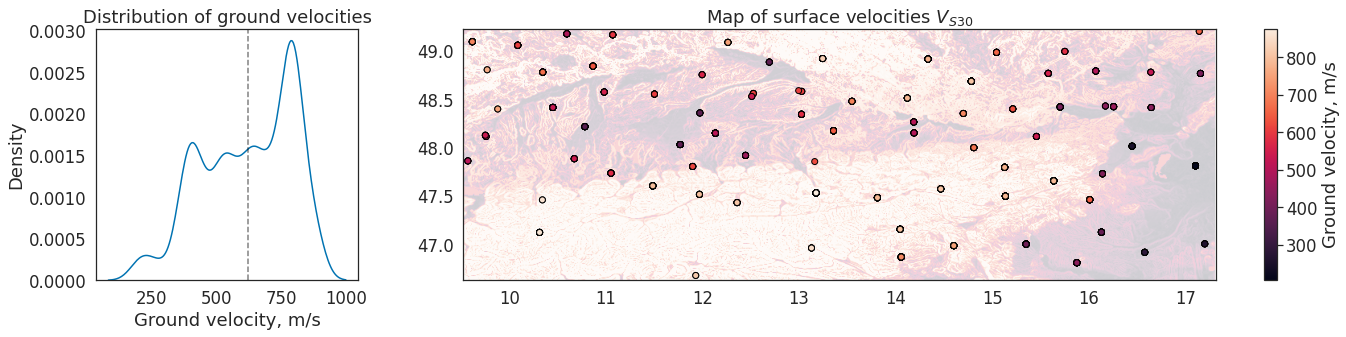

In [ ]:
#@title Produce Figure 10 (double-click to see the code)

# Extract ground velocities
g_vel = []
xs = []
ys = []

in_tif = '/content/thunder-seis/vs30_slope.tif'

for iloc in range(len(db_selected_without_times)):
    
    x1 = db_selected_without_times.iloc[iloc]['station_x']
    x2 = db_selected_without_times.iloc[iloc]['station_x']+0.1

    y1 = db_selected_without_times.iloc[iloc]['station_y']
    y2 = db_selected_without_times.iloc[iloc]['station_y']+0.1

    if x1 > x2:
        maxx = x1
        minx = x2
    else:
        maxx = x2
        minx = x1

    if y1 > y2:
        maxy = y1
        miny = y2
    else:
        maxy = y2
        miny = y1

    vs30 = crop_dem(minx, miny, maxx, maxy, in_tif, nodata=2.1474836e+09)
    if np.isnan(vs30).mean() != 1:
        ground_vel = vs30[~np.isnan(vs30)].mean()
        g_vel.append(ground_vel)
    else:
        g_vel.append(np.nan)
    
    xs.append(np.mean([x1,x2])) 
    ys.append(np.mean([y1,y2]))

# Construct station geopandas
gdf_stations = geopandas.GeoDataFrame(
    db_selected_without_times, geometry=geopandas.points_from_xy(db_selected_without_times.station_x, db_selected_without_times.station_y))
gdf_stations = gdf_stations.set_crs(epsg=4326)

gdf_stations = pd.merge(
                gdf_stations.drop_duplicates(subset='station'),
                gdf_stations.groupby('station')['amplitude'].count(),
                how="left",
                on='station',
)

# Plot maps
fig, ax = plt.subplots(ncols=2, figsize=(20,5))

ax_dist = plt.subplot2grid((1, 4), (0, 0))
ax_map = plt.subplot2grid((1, 4), (0, 1), colspan=3)

g_vel = np.array(g_vel)
sns.kdeplot(g_vel, ax=ax_dist)
ax_dist.set_xlabel('Ground velocity, m/s')
g_vel_mean = g_vel[~np.isnan(g_vel)].mean()
ax_dist.axvline(g_vel_mean, linestyle='--', color='black', alpha=0.5)

minx, miny, maxx, maxy = gdf_stations.geometry.total_bounds
full_map = crop_dem(minx, miny, maxx, maxy, in_tif, nodata=2.1474836e+09)

ax_map.imshow(full_map, extent=[minx, maxx, miny, maxy], alpha=0.2)
ax_map.set_xlim(minx,maxx)
ax_map.set_ylim(miny,maxy)
cmap = ax_map.scatter(xs,ys, edgecolor='black', c=g_vel)
cbar = plt.colorbar(cmap)    
cbar.set_label('Ground velocity, m/s')
ax_dist.set_title('Distribution of ground velocities')
ax_map.set_title('Map of surface velocities $V_{S30}$')

plt.tight_layout()
# plt.savefig('Ground_velocities.pdf')

**Figure 10**. Left panel: Distribution of ground velocities extracted from $V_{S30}$ map. 

Right panel: Map of surface velocities $V_{S30}$ over Austria and surrounding regions.

In [ ]:
#@title Produce figure A1 (double-click to see the code) 
def polarization_view(iloc, elev, azim, save):
    fig = plt.figure(figsize=(20,12))
    first_col = 2

    gs = fig.add_gridspec(nrows=8, ncols=6, hspace=0.0)
    ax_seismic_Z = fig.add_subplot(gs[0,:first_col])
    ax_seismic_N = fig.add_subplot(gs[1,:first_col], sharex=ax_seismic_Z, sharey=ax_seismic_Z)
    ax_seismic_E = fig.add_subplot(gs[2,:first_col], sharex=ax_seismic_Z, sharey=ax_seismic_Z)
    ax_spectrum = fig.add_subplot(gs[3,:first_col], sharex=ax_seismic_Z)
    ax_azimuth = fig.add_subplot(gs[4,:first_col], sharex=ax_seismic_Z)
    ax_incidence = fig.add_subplot(gs[5,:first_col], sharex=ax_seismic_Z)
    ax_altitude = fig.add_subplot(gs[6,:first_col], sharex=ax_seismic_Z)
    ax_rectiliniarity = fig.add_subplot(gs[7,:first_col], sharex=ax_seismic_Z)
        
    gs1 = fig.add_gridspec(nrows=8, ncols=6, hspace=1.5)
    ax_x = fig.add_subplot(gs1[:3,2:3])
    ax_y = fig.add_subplot(gs1[3:6,2:3])
    ax_z = fig.add_subplot(gs1[6:,2:3])
    
    ax_3D = fig.add_subplot(gs1[:,3:], projection='3d')
    
    db_for_pol = db_selected[db_selected.station == 'A027A']

    row  = db_for_pol.iloc[iloc] #Select record from database
    starttime = UTCDateTime(pd.Timestamp(row.timestamp)) - 30 #Set starttime
    endtime = UTCDateTime(pd.Timestamp(row.name)) + 60 #Set endtime

    freqs = [2., 49.0] #Select frequency range
    lightning_bound = 0.25

    record, record_filtered_ZNE, pol, attributes = compute_params(db_for_pol, iloc, freqs)
    
    if len(record) > 1:
        sr = record[0].stats.sampling_rate 
        trace = record_filtered_ZNE.select(channel='*Z')[0]

        ax_seismic_Z.plot(record_filtered_ZNE.select(channel='*Z')[0].times(), record_filtered_ZNE.select(channel='*Z')[0].data, color='black', linewidth=0.5, label='Z')
        ax_seismic_N.plot(record_filtered_ZNE.select(channel='*N')[0].times(), record_filtered_ZNE.select(channel='*N')[0].data, color='black', linewidth=0.5, label='N')
        ax_seismic_E.plot(record_filtered_ZNE.select(channel='*E')[0].times(), record_filtered_ZNE.select(channel='*E')[0].data, color='black', linewidth=0.5, label='E')
        
        for ax in [ax_seismic_Z, ax_seismic_N, ax_seismic_E]:
            ax.legend()
       
        ax_list = [ax_seismic_Z, ax_seismic_N, ax_seismic_E, ax_spectrum, ax_azimuth, ax_incidence, ax_rectiliniarity, ax_altitude]
        
        for ax in ax_list:
            ax.axvline(row['trig_on']/sr, color='green', alpha=0.5, linewidth=1.5)
            ax.axvline(row['trig_off']/sr, color='green', alpha=0.5, linewidth=1.5)
            
            arrival = (pd.Timestamp(row.name).timestamp()-starttime.timestamp) * sr
            origin = (pd.Timestamp(row['timestamp']).timestamp()-starttime.timestamp)*sr


        trace.spectrogram(dbscale=True, axes=ax_spectrum, cmap='inferno')
        ax_spectrum.set_ylim(freqs[0], freqs[1])

        pol['zenith'] = 90 - pol['incidence']

        data =  np.abs(record_filtered_ZNE[0].data)[::int(0.1*sr)][:len(pol['timestamp'])] +\
                np.abs(record_filtered_ZNE[1].data)[::int(0.1*sr)][:len(pol['timestamp'])] +\
                np.abs(record_filtered_ZNE[2].data)[::int(0.1*sr)][:len(pol['timestamp'])]
        
        rel_timestamp = pol['timestamp']- starttime.timestamp
            
        time = rel_timestamp[(rel_timestamp > row['trig_on']/sr) & (rel_timestamp < row['trig_off']/sr)]
        azimuth = pol['azimuth'][(rel_timestamp > row['trig_on']/sr) & (rel_timestamp < row['trig_off']/sr)]
        inc_angle = pol['incidence'][(rel_timestamp > row['trig_on']/sr) & (rel_timestamp < row['trig_off']/sr)]
        zenith_angle = 90 - inc_angle
        
        
        data_selected = data[(rel_timestamp > row['trig_on']/sr) & (rel_timestamp < row['trig_off']/sr)]
        distance = ((time-30) * 345)

        elevation = row['Elevation [km]']*1000
        
        x,y,z = pol2cart(distance, azimuth, inc_angle)
        
        gdf_station = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy([row.station_x], [row.station_y]))
        gdf_station_wgs = gdf_station.set_crs(epsg=4326)
        gdf_station = gdf_station_wgs.to_crs(epsg=3857)

        gdf_lightning = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy([row.st_x], [row.st_y]))
        gdf_lightning_wgs = gdf_lightning.set_crs(epsg=4326)
        gdf_lightning = gdf_lightning_wgs.to_crs(epsg=3857)
        
        x = x+gdf_station.geometry.x.values
        y = y+gdf_station.geometry.y.values
        z = z+elevation
            
        lightning_3d = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x, y))
        lightning_3d = lightning_3d.set_crs(epsg=3857)
        lightning_3d_deg = lightning_3d.to_crs(epsg=4326)

        ax_x.scatter(lightning_3d_deg.geometry.x.values, z, c=time, cmap='viridis', s=10, alpha=0.5)
        ax_y.scatter(lightning_3d_deg.geometry.y.values, z, c=time, cmap='viridis', s=10, alpha=0.5)
        
        ax_x.scatter(x=gdf_station_wgs.geometry.x.values, y=elevation, color='orange', s=100, marker='s')
        ax_x.scatter(x=gdf_lightning_wgs.geometry.x.values, y=elevation, color='red', marker='x', s=100)
        ax_y.scatter(x=gdf_station_wgs.geometry.y.values, y=elevation, color='orange', s=100, marker='s')
        ax_y.scatter(x=gdf_lightning_wgs.geometry.y.values, y=elevation, color='red', marker='x', s=100)
        
        ax_x.set_title('West-East view')
        ax_x.set_xlabel('X, deg')
        ax_x.set_ylabel('Altitude, m')
        ax_x.yaxis.tick_right()
        
        ax_y.set_title('North-South view')
        ax_y.set_xlabel('Y, deg')
        ax_y.set_ylabel('Altitude, m')
        ax_y.yaxis.tick_right()
        
        ax_z.scatter(lightning_3d_deg.geometry.x.values, lightning_3d_deg.geometry.y.values, c=time, cmap='viridis', s=10)
        ax_z.scatter(x=gdf_station_wgs.geometry.x.values, y=gdf_station_wgs.geometry.y.values, color='orange', s=100, marker='s')
        ax_z.scatter(x=gdf_lightning_wgs.geometry.x.values, y=gdf_lightning_wgs.geometry.y.values, color='red', marker='x', s=100)

        ax_3D.view_init(azim=azim, elev=elev)
        cbar_1=ax_3D.scatter(gdf_station.geometry.x.values-lightning_3d.geometry.x.values, gdf_station.geometry.y.values-lightning_3d.geometry.y.values,z,c=time-30, cmap='viridis', s=10, alpha=0.5)
        
        ax_3D.scatter(xs=0, ys=0, zs=elevation, color='orange', s=100, marker='s')
        ax_3D.scatter(xs=gdf_station.geometry.x.values-gdf_lightning.geometry.x.values, ys=gdf_station.geometry.y.values-gdf_lightning.geometry.y.values, zs=elevation, color='red', marker='x', s=100)
        
        ax_3D.set_title('3D view from azimuth %.1f deg' % azim)

        cbar_1=plt.colorbar(cbar_1, orientation='horizontal', shrink=0.5,)
        cbar_1.set_label('Time since lightning strike,s')
        ax_3D.set_xlabel('Meters from the station')

        ax_azimuth.scatter(pol['timestamp'] - starttime.timestamp, pol['azimuth'], s=5,
                        c=data,
                        vmin=np.median(data)*0.5,
                        vmax=np.median(data)*2,
                        cmap='Greys',
                        label='azimuth')
        
        true_azimuth = row['back_azimuth'] if row['back_azimuth'] < 180 else row['back_azimuth']-180
        ax_azimuth.axhline(true_azimuth, linestyle='dashed', color='red', alpha=0.5, label='back_azimuth')
        
        ax_incidence.scatter(pol['timestamp'] - starttime.timestamp, pol['zenith'], s=5, 
                        c=data,
                        vmin=np.median(data)*0.5,
                        vmax=np.median(data)*2,
                        cmap='Reds',
#                           color='red', 
                        label='Zenith')
        ax_altitude.scatter(time, z, s=5, 
                            c=data_selected,
                        vmin=np.median(data_selected)*0.5,
                        vmax=np.median(data_selected)*2,
                        cmap='Greens',
                        label='altitude')
        
        ax_rectiliniarity.scatter(pol['timestamp'] - starttime.timestamp, pol['rectilinearity'], s=5, 
                        c=data,
                        vmin=np.median(data)*0.5,
                        vmax=np.median(data)*2,
                        cmap='Blues',
                        label='rectilinearity')
        
        
        ax_seismic_Z.set_ylabel('Z disp, m')
        ax_seismic_N.set_ylabel('N disp, m')
        ax_seismic_E.set_ylabel('E disp, m')
        ax_spectrum.set_ylabel('Frequency, Hz')
        ax_azimuth.set_ylabel('Azimuth, deg')
        ax_incidence.set_ylabel('Zenith, deg')
        ax_altitude.set_ylabel('Altitude, m')
        ax_rectiliniarity.set_ylabel('Rectiliniarity')
        
        fig.subplots_adjust(hspace=1.5)   
        plt.suptitle('iCloud=%s, Amplitude=%.2f kA, id=%i, %s, Distance=%i m' % (row['icloud'], row['amplitude'], row['num'], row['station'], row['distance']))
    if save:
        fig.savefig('Lightning_reconstruction_%i.pdf' % row['id'])
#     else:
#         print('Ama bad boy')

interact(polarization_view, 
        iloc=widgets.IntSlider(value=0, min=0, max=len(db_selected[db_selected.station == 'A027A'])-1, step=1, description='iloc:', 
                           readout=True, readout_format='d'),
        elev=widgets.IntSlider(value=15, min=0, max=90, step=5, description='3d view: elevation', 
                           readout=True, readout_format='d'),
        azim=widgets.IntSlider(value=15, min=0, max=360, step=5, description='3d view: azimuth', 
                           readout=True, readout_format='d'),
        save = widgets.ToggleButton(value=False, description='Save', disabled=False, 
                                    tooltip='Description', icon='save'),
        )

**Figure A1**. Reconstruction of a lighntnig channel using single station polarization analysis.Data were filtered with a bandpass zero-phase filter from 2 to 49 Hz. The left panel demonstrates seismic displacement recorded on channels Z, N, and E, as well as output of polarization analysis (azimuth, zenith angle, altitude, rectilinearity). The middle panel demonstrates the West-East view, North-South view, and Top view with the terrain. The right panel demonstrates a 3D reconstruction of a lightning shape. Note that time is shown in color, from dark blue (early time) to yellow (later time).

Note, this is an interactive figure. You can select an event, and view the reconstruction from different angles (azimuthal and elevation)